In [1]:
# Load Transaction Data from a CSV File

### DISCLAIMER: 
### FOR ALL TAX-RELATED QUESTIONS AND CONCERNS PLEASE ASK A CERTIFIED ACCOUNTANT

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# TODO: move your MINT.com transactions.csv into this project directory
# / the directory where you are running jupyter notebook
PATH_TO_YOUR_TRANSACTIONS = "transactions.csv"
PATH_TO_RENTS = "rents.csv"

# Set the name of the column where the transactions are categorized
# In Mint this is usually "Category".  I use Mint's category to link 
# transactions to a property and the add a seperate "Label" column
# after exporting the data for a property from Min
CATEGORY = "Label"

# Name of the Label we'll use for each units share of the shared expenses
SHARED_EXPENSE = 'ZZZ of Shared Expenses'


# Load the transaction data from the csv into a dataframe
parse_dates = ['Date']
df = pd.read_csv(PATH_TO_YOUR_TRANSACTIONS, parse_dates=parse_dates)
df.set_index(['Date'], inplace=True)
df['Amount'] = df['Amount'].astype(float)

# Get rid of Mint columns that we don't care about
df.drop(['Original Description','Actual Amount','Notes'], axis=1, inplace=True)
df.sort_index(inplace=True)
df.head()

,Description,Amount,Transaction Type,Category,Account Name,Label,Unit
Date,,,,,,,
2016-09-23,Transunion - Credit Freeze Lift,5.00,debit,122 Spring St,Citi Double Cash Card,Closing,NaN
2016-10-10,Experian Credit Freeze Lift for Mortgage,5.44,debit,122 Spring St,Citi Double Cash Card,Closing,NaN
2016-10-11,Equifax Credit Freeze Lift for Mortgage,5.00,debit,122 Spring St,Citi Double Cash Card,Closing,NaN
2016-10-20,Check 1118- Housemaster Home Insp. of 122 Spri...,495.00,debit,122 Spring St,INTEREST CHECKING,Closing,NaN
2016-10-24,"Check 1114- Miranda Realty, 122 Spring",2000.00,debit,122 Spring St,INTEREST CHECKING,Closing,NaN


In [2]:
# Find all the categories that have both credits and debits and adjust the overall expense
two_cats_df = df
for label in df[CATEGORY].unique():
    if df[df[CATEGORY] == label]['Transaction Type'].nunique() <= 1:
        two_cats_df = two_cats_df[two_cats_df[CATEGORY] != label]

# Convert the credits to negative debits so that these will be viewed as expenses
def find_refunds(row):
    """ Look for transactions that have a
        credit for a typical "spending" label
        Change these to a debit with a negative
        amount.

        This results in the refunds getting subtracted
        from the total spend calculations
    """
    if row['Transaction Type'] == 'credit':
        print (row[CATEGORY]+' -- Credit on ' + row.name.strftime('%m/%d/%Y') + ' from '+ \
               row.Description + ' for ${:,.2f}'.format(row.Amount))
        row.Amount *= -1
        row['Transaction Type'] = 'debit'
    return row

print('Below are the transactions that were "credits" in categories that we consider expenses:\n')

for label in two_cats_df[CATEGORY].unique():
    df[df[CATEGORY] == label] = df[df[CATEGORY] == label].apply(find_refunds, axis=1)

print('\nThe overall expense totals in these categories have been adjusted with these credits.')


Below are the transactions that were "credits" in categories that we consider expenses:

Closing -- Credit on 01/23/2017 from Sefcu Iteller Ppd 122 Spring Tax Adjustment for $176.44
Closing -- Credit on 02/07/2017 from Sefcu Iteller Ppd 122 Spring Tax Adjustment for $139.00
Supplies -- Credit on 01/07/2017 from Home Depot - Dryer Vent Stuff for $41.91
Supplies -- Credit on 09/04/2017 from Home Depot - Dryer Vent Stuff for $9.63
Supplies -- Credit on 06/07/2018 from Home Depot - Different bits for $17.25
Supplies -- Credit on 10/13/2018 from Home Depot -repair parts for vacant apts for $56.13
Supplies -- Credit on 10/28/2018 from Home Depot - Returned shelf parts for $27.74
Mortgage -- Credit on 01/05/2017 from City Tax Payment from Escrow for $1,843.66
Mortgage -- Credit on 09/13/2017 from School Tax Payment from Escrow for $2,942.90
Mortgage -- Credit on 01/05/2018 from City Tax Payment from Escrow for $2,337.97
Mortgage -- Credit on 03/12/2018 from 122 Spring Street Escrow Refund for

In [3]:
# Set the colors that we'll use in our visualizations
num_categories = len(df[CATEGORY].unique()) + 1

# Seaborn lets us specify the number of colors in a pallette
# so we set it to the number of categories we may visualize
import seaborn as sns
sns.set_palette(sns.color_palette("Paired", num_categories))

# Uncomment this to see the colors in the pallet
#sns.palplot(sns.color_palette("Paired", num_categories))

# Create a "color dictionary" that maps each label to a unique color
colordict={}
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
num = 0
for label in df[CATEGORY].unique():
    colordict[label]=colors[num]
    num += 1
# I manually add a "SHARED_EXPENSE" label for use when visualizing per unit costs
colordict[SHARED_EXPENSE]=colors[num]

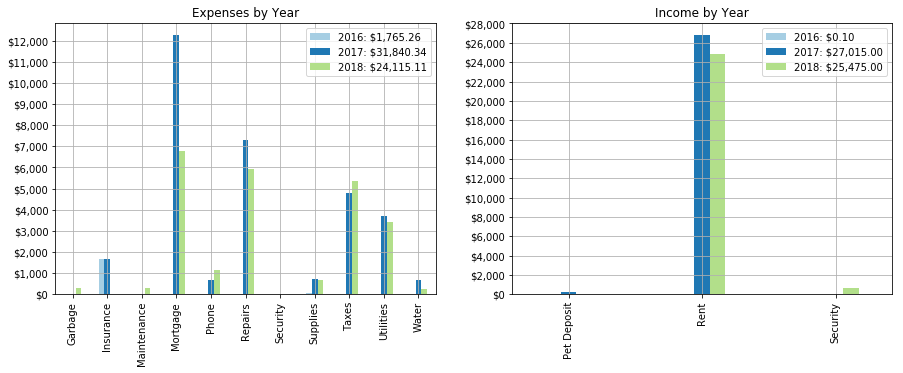

In [4]:
# Visualize Year over Year Expenses and Income by Category
# Get the expense and income data
expenses_df = df[df['Transaction Type'] == 'debit']
income_df = df[df['Transaction Type'] == 'credit']

# We exclude closing costs from the year over year expense visualization
expenses_df = expenses_df[expenses_df[CATEGORY] != 'Closing']

# Group the expenses and income by category and year
g = expenses_df.groupby([CATEGORY, expenses_df.index.year])
expenses = g.sum()
g = income_df.groupby([CATEGORY, income_df.index.year])
income = g.sum()

# If any "expenses" were actually income in a given year add them to income
# For example, this could happen when we took in more security than we paid out
expense_as_income = expenses[expenses['Amount'] < 0]
if not expense_as_income.empty:
    expenses = expenses[expenses['Amount'] >= 0]
    expense_as_income = expense_as_income.abs()
    income = income.append(expense_as_income)
   
# Visualize by category per year, legend will have annual totals
# We will have to plots side by side
ax1 = plt.subplot(1,2,1)
expenses.unstack(-1).plot.bar(title='Expenses by Year', figsize=[15,5], grid=True, width=0.5, ax=ax1)
ax2 = plt.subplot(1,2,2)
income.unstack(-1).plot.bar(title='Income by Year', figsize=[15,5], grid=True, width=0.35, ax=ax2)

# Calculate and store the expense/income for each year
e_totals = expenses.sum(level=['Date'])
e_totals.sort_index(inplace=True)
i_totals = income.sum(level=['Date'])
e_totals.sort_index(inplace=True)
totals_df = pd.DataFrame(columns=['Year', 'Expenses', 'Income'])
totals_df.set_index('Year', inplace=True)   
e_legend_labels = []
i_legend_labels = []
for year in e_totals.index:
    e_legend_labels.append(str(year) + ': ${:,.2f}'.format(e_totals.loc[year, 'Amount']))
    i_legend_labels.append(str(year) + ': ${:,.2f}'.format(i_totals.loc[year, 'Amount']))
    totals_df.loc[year] = [e_totals.loc[year, 'Amount'], i_totals.loc[year, 'Amount']]
# Show the totals on the plot legends
ax1.legend(e_legend_labels)
ax2.legend(i_legend_labels)

# Format the yticks as currency, and remove the x-labels
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax1.yaxis.set_major_formatter(tick) 
ax2.yaxis.set_major_formatter(tick) 
tick_spacing = 1000
ax1.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))
ax1.set_xlabel('')
tick_spacing = 2000
ax2.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))
ax2.set_xlabel('')

# Semicolot after plot hides a bunch of garbage showing in jupyter
plt.show();

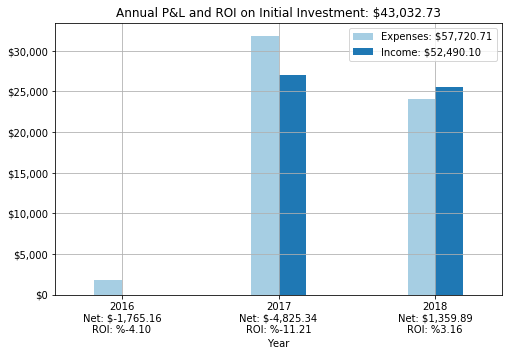

In [5]:
# Visualize Annual P&L and ROI
# Extract the Closing Costs to be used for our Annual ROI against original investment
initial_investment = df[df[CATEGORY] == 'Closing']['Amount'].sum()
# print('The initial investment for ROI calculations is: ${:,.2f}'.format(initial_investment))

# Do a final Visualization that just shows the sum of income and expense per year
# X axis should show the year, net income, and ROI against closing costs
ax = plt.subplot()
title = 'Annual P&L and ROI on Initial Investment: ${:,.2f}'.format(initial_investment)
totals_df.sort_index(inplace=True)
totals_df.plot.bar(title=title, figsize=[8,5], grid=True, width=0.35, ax=ax)

# Show the net cost on the legend
legend_labels = ['Expenses: ${:,.2f}'.format(totals_df['Expenses'].sum()), \
                 'Income: ${:,.2f}'.format(totals_df['Income'].sum())]
ax.legend(legend_labels)
x_labels = []
for year,row in totals_df.iterrows():
    net = row.loc['Income'] - row.loc['Expenses']
    x_labels.append(str(year) + '\nNet: ${:,.2f}'.format(net) + \
                    '\nROI: %{:,.2f}'.format(net/initial_investment*100))                                        
ax.set_xticklabels(x_labels, rotation=0)

# Format the yticks as currency
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 
tick_spacing = 5000
ax.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing))

# Semicolot after plot hides a bunch of garbage showing in jupyter
plt.show();

In [6]:
# Function to visualize the expenses for the year by category
def visualize_year(year, year_df, colordict):
    """ Build a pie chart that visualizes the
        expenses for a year
    """
    expenses_df = year_df[year_df['Transaction Type'] == 'debit']
    expenses = expenses_df.groupby([CATEGORY]).sum()
    
    income_df =  year_df[year_df['Transaction Type'] == 'credit']
    income = income_df.groupby([CATEGORY]).sum()
    income_for_year = income.Amount.sum()

    ax = plt.subplot()
    # Build a legend for a Pie Chart that includes the Spending Category and the Amount
    legend_label = []
    for idx in expenses.index:
        if expenses.loc[idx].Amount < 0:
            print(year + ': Converting ' + idx + ': ${:,.2f}'.format(expenses.loc[idx].Amount) + ' to income.')
            income_for_year -= expenses.loc[idx].Amount
            expenses.drop([idx], inplace=True)
        else:
            legend_label.append(idx + ': ${:,.2f}'.format(expenses.loc[idx].Amount))
    #plt.legend(legend_label,loc='center left', bbox_to_anchor=(1.5, 0.5))
        
    # Include income in the title, even though the plot is for expenses
    title = year + ' Expenses: '+ '${:,.2f}'.format(expenses.Amount.sum()) + '\n' + year + \
            ' Income: ${:,.2f}'.format(income_for_year)
    ax.set_title(title)

    # Set the colors consistently across versions of this plot
#     ax = expenses.plot(kind='pie', y='Amount', figsize=(8,8), title=title, subplots=True)
#     ax
#    pie_wedge_collection = ax.pie(slices, labels=labels, labeldistance=1.05)#, autopct=make_autopct(slices))
    pie_wedge_collection = ax.pie(expenses['Amount'], labels=expenses.index) #, title=title, figsize=(8,8), labels=labels, labeldistance=1.05)#, autopct=make_autopct(slices))
    pie_wedge_collection
    for pie_wedge in pie_wedge_collection[0]:
        pie_wedge.set_edgecolor('white')
        pie_wedge.set_facecolor(colordict[pie_wedge.get_label()])
    ax.legend(legend_label,loc='center left', bbox_to_anchor=(1.5, 0.5))
    # Plot it
    plt.show()

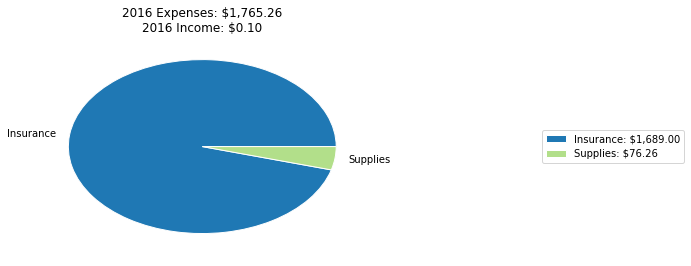

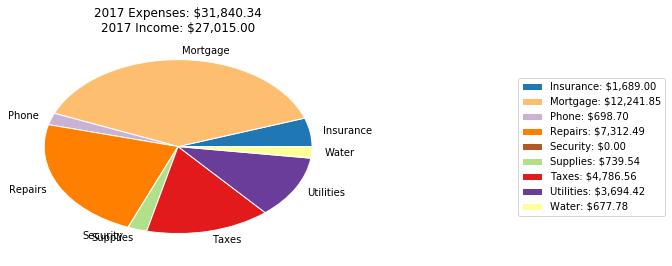

2018: Converting Security: $-625.00 to income.


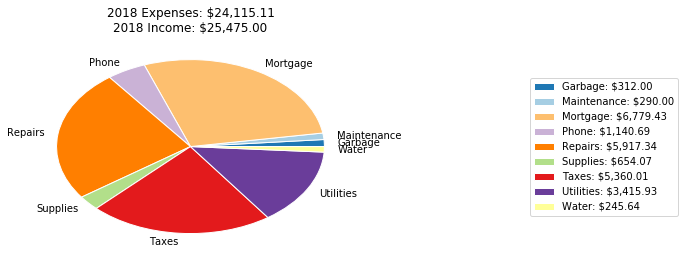

In [7]:
## Visualize the expenses by category per year

# We'll exclude closing costs for the year over year expenses
df = df[df[CATEGORY] != 'Closing']

for YEAR in df.index.year.unique():
    year_df = df[df.index.year == YEAR]
    visualize_year(str(YEAR), year_df, colordict)


In [8]:
# Function to create an individual plot for a unit

def plot_stacked_bar_groups(ax, df, title, width, figsize, legend, colors, years, tick_spacing):
    pivot_df = df.pivot(index='Transaction Type', columns='Label', values='Amount')
    pivot_df.plot.bar(title=title, stacked=True, figsize=figsize, grid=True, width=width, \
                      legend=legend, color=colors, ax=ax);

    # Move back every second patch (bar element) left, so the expensese are next to the credit
    for patch in range(1, len(ax.patches), 2):
        new_x = ax.patches[patch].get_x() - width
        ax.patches[patch].set_x(new_x);
        
        
    # Update tick locations correspondingly
    num_bars = 2 * len(years)
    minor_tick_locs = [x.get_x()+1/4 for x in ax.patches[:num_bars]]
    minor_tick_labels = []
    for group in range(0, num_bars, 2):
        minor_tick_labels.extend(['I', 'E'])
    ax.set_xticks(minor_tick_locs, minor=True);
    ax.xaxis.set_ticklabels(minor_tick_labels, minor=True)

#    major_tick_locs = np.array([x.get_x()+1/4 for x in ax.patches[:num_bars]]).reshape(3, 2).mean(axis=1)
    group_locs = minor_tick_locs[0::2]
    major_tick_locs = [ x+1/4 for x in group_locs]
    ax.set_xticks(major_tick_locs)
    ax.xaxis.set_ticklabels(years)
    
    # Remove ticks and organize tick labels to avoid overlap
    ax.tick_params(axis='x', which='both', bottom='off')
    ax.tick_params(axis='x', which='minor')
    ax.tick_params(axis='x', which='major', pad=25, rotation=0)
                            
    # Format the yticks as currency, and remove the x-labels
    fmt = '${x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt);
    ax.yaxis.set_major_formatter(tick);
    ax.yaxis.set_major_locator(mtick.MultipleLocator(tick_spacing));
    ax.set_xlabel('');


,2F,1W,1E
Year,,,
2017,1100,700,650
2018,1100,700,700
2019,1150,800,700


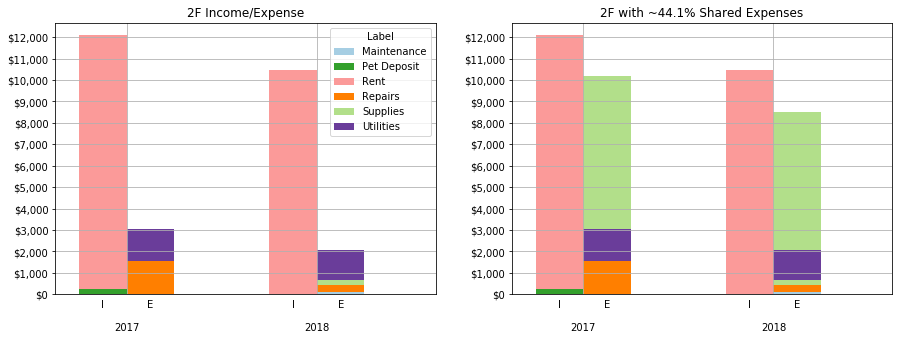

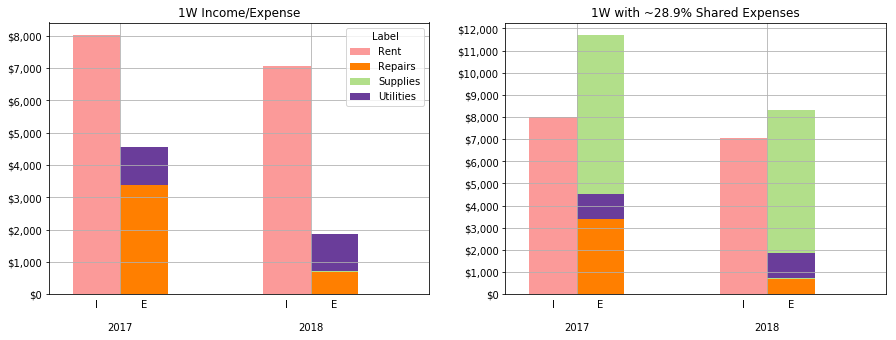

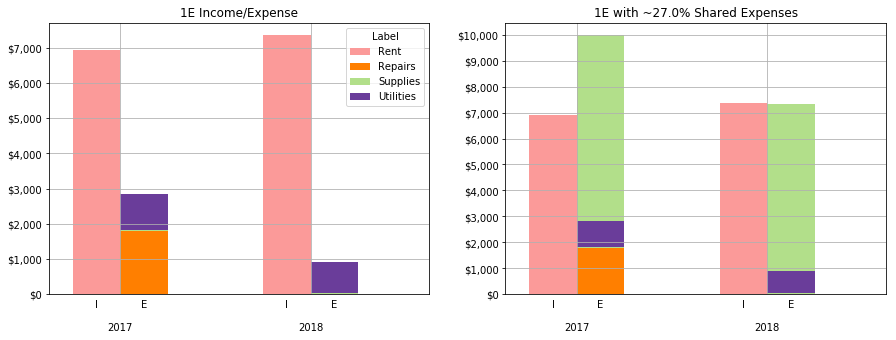

In [10]:
## Visualize the income and expenses by by unit

# Read in the rents data
rents = pd.read_csv(PATH_TO_RENTS)
rents.set_index(['Year'], inplace=True)
rents

# We'll exclude closing costs for the year over year expenses
df = df[df[CATEGORY] != 'Closing']
# Security is its own liability and asset so lets exclude it too
df = df[df[CATEGORY] != 'Security']

for unit in rents.columns:
    # Create empty dataframews that we will build year over year
    unit_df = pd.DataFrame(columns=['Label','Transaction Type','Amount'] )
    unit_with_shared_df = pd.DataFrame(columns=['Label','Transaction Type','Amount'] )
    year_labels = []
    
    for YEAR in df.index.year.unique():
        if YEAR == 2016:
            continue  # No real data for 2016

        # Grab the data for the unit for each year
        year_df = df[df.index.year == YEAR]
        shared_expenses_df = year_df[year_df["Unit"].isna()]
        unit_data = year_df[year_df["Unit"] == unit]
        year_labels.append(YEAR)

        # Group the expenses and income by category
        g = unit_data.groupby([CATEGORY, 'Transaction Type'])
        totals = g.sum().reset_index()
        # Create a unique debit/credit index for each year
        totals['Transaction Type'] = str(YEAR) + '-' + totals['Transaction Type'].astype(str) 
        # Add this years data to the totals for this unit
        unit_df = unit_df.append(totals, ignore_index=True)
        # An alternate dataframe includes each units share of the shared expenses
        unit_with_shared_df = unit_with_shared_df.append(totals, ignore_index=True)
        # Calculate the units share of expenses as the ratio of its rent        
        share = rents.loc[YEAR][unit] / rents.loc[YEAR].sum()
        unit_with_shared_df.loc[len(unit_with_shared_df.index)] = [SHARED_EXPENSE, str(YEAR) + '-debit', \
                                                                   shared_expenses_df.Amount.sum()/3]

    # Visualize the income and expenses for this unit year after year

    # Set the attributes and colors for the labels so they are consistent
    width = 0.5
    figsize=[15,5]
    tick_spacing = 1000
    legend = True;
    colors = []
    labels = unit_with_shared_df.Label.unique()
    for label in sorted(labels):
        colors.append(colordict[label])

    # First plot without the shared expenses
    ax1 = plt.subplot(1,2,1)
    title = str(unit) + ' Income/Expense'    
    plot_stacked_bar_groups(ax1, unit_df, title, width, figsize, \
                            legend, colors, year_labels, tick_spacing)

    # Second plot includes this units share of the shared expenses
    ax2 = plt.subplot(1,2,2)
    legend = False;
    avg_percent_of_shared_expensese = rents[unit].sum() / rents.values.sum()
    title=str(unit)+' with ~{:.1%}'.format(avg_percent_of_shared_expensese) + ' Shared Expenses'
    plot_stacked_bar_groups(ax2, unit_with_shared_df, title, width, figsize, \
                            legend, colors, year_labels, tick_spacing)

    # Show the plots
    plt.show();